In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import shutil
import time
import random
from nilearn import datasets, image
from nilearn.image import load_img, index_img
from nilearn.plotting import plot_epi
from nilearn.maskers import NiftiLabelsMasker
from nilearn.masking import apply_mask
import nibabel as nib
# from PyIF import te_compute as te
from joblib import delayed, Parallel
import pandas as pd
from scipy.stats import zscore
from scipy.optimize import curve_fit
from scipy.signal import convolve
from joblib import Parallel, delayed
import glob
from utils.data_loader import DataLoader
from utils.plotting import plot_voxels, plot_w_fit
from utils.relaxation_time import RelaxationTime
from utils.timer import TimerController

# import seaborn as sns
import scienceplots

plt.style.use(['science','no-latex', 'ieee'])
plt.rcParams.update({
    "font.family": "DejaVu Sans",   # specify font family here
})

In [2]:
root_dir = '/scratch/anirudh.palutla/adni/preproc'
SCRATCH_DATA_DIR = '/scratch/anirudh.palutla/tmp/'
Z_SK_DATA_SAVE_DIR = "/scratch/anirudh.palutla/adni/z_sk_data"
PRINT_TIME_INTERVAL = 20


global timers
timers = TimerController()

if not os.path.exists(SCRATCH_DATA_DIR): os.makedirs(SCRATCH_DATA_DIR)

dloader = DataLoader(root_dir, z_sk_dir=Z_SK_DATA_SAVE_DIR)
subjects_list = dloader.subjects_list
len(dloader.subjects_list)

89

In [3]:
def get_masked_roi_signal(func_img, mask, aal_atlas):
    func_img_aal = image.resample_to_img(func_img, aal_atlas)
    func_masked = apply_mask(func_img_aal, mask)
    return func_masked

In [4]:
def exp_fn(x, a, b):
    return a * np.power(x, -b)

In [8]:
# def get_conv_data(ts, N):
#     kernel = np.ones((N, N, N))
#     kernel /= np.sum(kernel) # Normalize the kernel

# #     smoothed_data = np.zeros(ts.shape)
# #     for t in range(ts.shape[-1]):
# #         smoothed_data[:,:,:,t] = convolve(ts[:,:,:,t], kernel, mode='same')
#     smoothed_data = convolve(ts[:,:,:], kernel, mode='same')
# #     mean_signal = np.mean(smoothed_data, axis=3)
# #     var_signal = np.var(smoothed_data, axis=3)

#     return smoothed_data
# #     SRV = var_signal / np.power(mean_signal, 2)
# #     return SRV

In [9]:
# def get_avg_ts(ts, avg_level=1):
#     new_ts = []
    
#     for i in range(0, ts.shape[0]-avg_level+1, avg_level):
#         ts_i = []
#         for j in range(0, ts.shape[1]-avg_level+1, avg_level):
#             ts_j = []
#             for k in range(0, ts.shape[2]-avg_level+1, avg_level):
#                 avg_ts_ijk = np.mean(
#                     ts[
#                         i:i+avg_level, 
#                         j:j+avg_level, 
#                         k:k+avg_level], 
#                     axis=(0, 1, 2)
#                 )
#                 ts_j.append(avg_ts_ijk)
#             ts_i.append(ts_j)
#         new_ts.append(ts_i)
#     new_ts = np.array(new_ts)
#     return new_ts

In [10]:
# def get_rx(ts, ns):
#     rxs = []
#     for n in ns:
#         print(f'At n={n}')
#         x = get_avg_ts(ts, n)
# #         x = get_realisations(ts, n)
#         x_mean = np.mean(x)
#         x_var = np.var(x)
#         rxs.append(x_var/(x_mean ** 2))
#     return rxs

In [5]:
# def get_realisations(ts, n):
#     realisations = []
#     T_max = len(ts)
#     for i in range(0, T_max - int(n), n):
#         realisations.append(np.mean(ts[i:i+n]))
#     return np.array(realisations)

# def get_c_realisations(ts, n):
#     center = len(ts)//2
#     realisations = ts[center:center+n]
# #     print("Indices", center, center+n)
#     return realisations

def get_nsamples_realisations(ts, n, nsamples):
#     rinds = random.sample(range(0, len(ts), n), nsamples)
    rinds = np.random.choice(np.arange(0, len(ts), step=n), size=nsamples, replace=False)
    realisations = np.array([ np.mean(ts[i:i+n]) for i in rinds ])
#     print("inds:", rinds)
    return realisations

def get_rx_1d(ts, ns, t=0, nsamples=1000):
    rxs = []
#     print("Running for ns = ", ns)
#     ts = dloader.get_func(sub).get_fdata()[:, :, :, t]
    ts = ts.flatten()
    for n in ns:
#         x = get_conv_data(ts, n)
#         x = get_c_realisations(ts, n)
#         print(f'At n={n};',end='\t')
        x = get_nsamples_realisations(ts, n, nsamples)
#         print(f'\tGot {len(x)} samples')
        x_mean = np.mean(x)
        x_var = np.var(x)
        rxs.append(x_var/(x_mean ** 2))
    return rxs

In [6]:
def get_masked_sub_rxs(dloader, subs, kernel_sizes, nsamples, t=50, rx_fn=get_rx_1d, save=None, zscored=False):
    mask = nib.load('Frontal_Mid_R_MASK.nii.gz')
    aal = datasets.fetch_atlas_aal()
    aal_atlas = nib.load(aal.maps)
    
    if not os.path.exists(save): os.makedirs(save)
    timers.start_timer("stsx")
    
    sub_rxs = []
    for sub_idx in range(len(subs)):
        timers.start_timer("stsb")
        sub = subs[sub_idx]
        if zscored == False:
            func = index_img(dloader.get_func(sub), t)
        else:
            func = dloader.get_z_sk_func(sub)[:, t]
        ts = get_masked_roi_signal(func, mask, aal_atlas)
        print(ts.shape)
#         ts = dloader.get_skstrip_func_flat(sub)[:, t]
#         np.random.shuffle(ts)
        rxs = rx_fn(ts, kernel_sizes, nsamples=nsamples)
        sub_rxs.append(rxs)
        del ts
        
        if type(save) != type(None):
            np.save(os.path.join(save, sub + "-rxs.npy"), rxs)
        print(f"Done with subject ({sub_idx}) {subs[sub_idx]}; took {timers.get_elapsed_time('stsb')}")
    print(f"Finished in {timers.get_elapsed_time('stsx')}")
    return sub_rxs

In [7]:
def zscore_sk_subs(dloader, savedir=False):
    for i in range(len(dloader.subjects_list)):
        sub = dloader.subjects_list[i]
        ts = dloader.get_skstrip_func_flat(sub)
        z_ts = zscore(ts, axis=1)
        print(str(i), end=" ")
        if savedir != False:
            if not os.path.exists(savedir): os.makedirs(savedir)
            np.save(os.path.join(savedir, f"{sub}_z-sk-ts.npy"), z_ts)
    return

# zscore_sk_subs(dloader, savedir=Z_SK_DATA_SAVE_DIR)

In [8]:
def get_avg_sub_ts_rxs(dloader, subs, kernel_sizes, nsamples, t=50, rx_fn=get_rx_1d, save=None, zscored=False):
    if not os.path.exists(save): os.makedirs(save)
    timers.start_timer("stsx")
    
    avg_ts = np.zeros(shape=dloader.get_skstrip_func_flat(0)[:, t].shape)
    for sub_idx in range(len(subs)):
        timers.start_timer("stsb")
        sub = subs[sub_idx]
        if zscored == False:
            ts = dloader.get_skstrip_func_flat(sub)[:, t]
        else:
            ts = dloader.get_z_sk_func(sub)[:, t]
        nonan_ts = np.nan_to_num(ts)
        avg_ts += nonan_ts
        del ts
        del nonan_ts
        print(f"Done with subject ({sub_idx}) {subs[sub_idx]}; took {timers.get_elapsed_time('stsb')}")
        
    rxs = rx_fn(avg_ts, kernel_sizes, nsamples=nsamples)
        
    if type(save) != type(None):
        np.save(os.path.join(save, "avg-rxs.npy"), rxs)
    print(f"Finished in {timers.get_elapsed_time('stsx')}")
    return rxs

In [9]:
def get_sub_rxs(dloader, subs, kernel_sizes, nsamples, t=50, rx_fn=get_rx_1d, save=None, zscored=False):
    if not os.path.exists(save): os.makedirs(save)
    timers.start_timer("stsx")
    
    sub_rxs = []
    for sub_idx in range(len(subs)):
        timers.start_timer("stsb")
        sub = subs[sub_idx]
#         ts = dloader.get_func(sub).get_fdata()[:, :, :, t].flatten()
        if zscored == False:
            ts = dloader.get_skstrip_func_flat(sub)[:, t]
        else:
            ts = dloader.get_z_sk_func(sub)[:, t]
#         np.random.shuffle(ts)
        rxs = rx_fn(ts, kernel_sizes, nsamples=nsamples)
        sub_rxs.append(rxs)
        del ts
        
        if type(save) != type(None):
            np.save(os.path.join(save, sub + "-rxs.npy"), rxs)
        print(f"Done with subject ({sub_idx}) {subs[sub_idx]}; took {timers.get_elapsed_time('stsb')}")
    print(f"Finished in {timers.get_elapsed_time('stsx')}")
    return sub_rxs

In [10]:
def gaussian(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [11]:
def load_rxs_data(save_dir, t=1):
    kernel_sizes = np.load(os.path.join(save_dir, "kernel_sizes.npy"))
    subs = np.load(os.path.join(save_dir, "subs.npy"))
    # Loading saved sub_rxs
    sub_rxs = []
    for sub in dloader.subjects_list:
        sub_rxs.append(np.load(os.path.join(save_dir, str(t), sub + '-rxs.npy')))
    sub_rxs = np.array(sub_rxs)
    return kernel_sizes, sub_rxs, subs

#### Save file info
- `fns_t1`: Updated $R_x$ calculation with fixed number of samples in each realisation
- `fns_t2`: Updated $R_x$ calculation with smaller number of samples 
- `fns_t3`: Updated $R_x$ calculation; $nsamples = 30$, kernels = $(1, 1000, n=500)$
- `msk_t1`: $R_x$ calculation for masked ROI for voxels within `Frontal_Mid_R_MASK.nii.gz`
- `z_t1` : $R_x$ calculation after z-scoring
- `z_t2` : $R_x$ calculation after z-scoring
- `z_t3` : $R_x$ calculation after z-scoring for $t=100$
- `z_avg_t1` : $R_x$ calculation after z-scoring for $t=50$ with averaging over subjects 
- `z_t4` : $R_x$ calculation after z-scoring for $t=100$

In [ ]:
if __name__ == "__main__":
    RXS_SAVE_NAME = "z_t3"
    RXS_SAVE_DIR = f"./results/rxs/{RXS_SAVE_NAME}"
    PLOTS_SAVE_PARENT_DIR = f"./results/plots/{RXS_SAVE_NAME}"
    Z_SK_DATA_SAVE_DIR = "/scratch/anirudh.palutla/adni/z_sk_data"
    
    if not os.path.exists(RXS_SAVE_DIR): os.makedirs(RXS_SAVE_DIR)
    if not os.path.exists(PLOTS_SAVE_PARENT_DIR): os.makedirs(PLOTS_SAVE_PARENT_DIR)
    
    FITS_SAVE_FP = "./results/rxs/fits.npz"

    root_dir = '/scratch/anirudh.palutla/adni/preproc'
    SCRATCH_DATA_DIR = '/scratch/anirudh.palutla/tmp/'

    if not os.path.exists(SCRATCH_DATA_DIR): os.makedirs(SCRATCH_DATA_DIR)

    dloader = DataLoader(root_dir, z_sk_dir=Z_SK_DATA_SAVE_DIR)
    subjects_list = dloader.subjects_list

    kernel_min, kernel_max = 1, 1000
    n_kernels = 500
    nsamples = 30
    trunc_lim = 25
    kernel_sizes = np.ceil(np.linspace(kernel_min, kernel_max, n_kernels)).astype(int)
    t_range = range(2, 50)
    subs = dloader.subjects_list
        
    np.save(os.path.join(RXS_SAVE_DIR, "kernel_sizes.npy"), kernel_sizes)
    np.save(os.path.join(RXS_SAVE_DIR, "subs.npy"), subs)
    np.save(os.path.join(RXS_SAVE_DIR, "nsamples.npy"), nsamples)
    for t in t_range:
        # For all subjects
        sub_rxs = get_sub_rxs(
            dloader, subs, kernel_sizes, nsamples, 
            t=t, 
            save=os.path.join(RXS_SAVE_DIR, str(t)),
            zscored=True,
        )
        print(f"Done with time {t}")

#         # For average over subjects
#         sub_rxs = [ get_avg_sub_ts_rxs(
#             dloader, subs, kernel_sizes, nsamples, 
#             t=t, 
#             save=os.path.join(RXS_SAVE_DIR, str(t)),
#             zdir = Z_SK_DATA_SAVE_DIR,
#         ), ]
    
    
    sub_rxs = np.array(sub_rxs)


In [121]:
# def plot_rxs_realisations(kernel_sizes, sub_rxs, subs=None, fits=None):
#     if subs == None: subs = list(range(len(sub_rxs)))
        
#     fig, ax = plt.subplots()
#     realisations = np.floor(228938/kernel_sizes)
#     N_log = np.log(realisations)
#     for i, sub in zip(range(len(sub_rxs)), subs):
#         rx = sub_rxs[i]
#         rx_log = np.log(rx)
    
#         c = [np.random.rand(), np.random.rand(), np.random.rand()] 
# #         ax.plot(ns_log, rx_log, label=f'{i}-og', c=c)
#         ax.plot(N_log, rx_log, label=f'{i}-og', c=c)
#         if type(fits) != type(None):
#             ax.plot(N_log, np.polyval(fits[i], N_log), label=f'{fits[i][0]:.3f}', c=c, linestyle='--')
        
#     plt.title("Relative Variance Scaling with System Size")
#     ax.set_ylabel("$log(r_x)$")
#     ax.set_xlabel("$log(N_{sys})$")
    
#     ticks = ax.get_xticks()[1:]
#     ticks = np.linspace(min(ticks), max(ticks), 7)
#     new_labels = [ f"\n{i:.2f}" for i in ticks ]
#     ax.set_xticks(ticks)
#     ax.set_xticklabels(new_labels)

#     ax.set_xticks(N_log, minor=True)
#     ax.set_xticklabels(["`"]*len(N_log), minor=True)
    
# #     plt.legend()
#     plt.show()

In [122]:
# # Rxs loading code

# # RXS_SAVE_DIR = "./results/rxs/0"
# RXS_SAVE_DIR = "./results/rxs/s1"
# FITS_SAVE_FP = "./results/fits.npz"
# timestep = 1

# trunc_lim = 5
# kernel_sizes = np.load(os.path.join(RXS_SAVE_DIR, "kernel_sizes.npy"))
# subs = np.load(os.path.join(RXS_SAVE_DIR, "subs.npy"))
# sub_rxs = []
# for sub_idx in range(len(subs)):
#     sub = subs[sub_idx]
#     sub_rxs.append(np.load(os.path.join(RXS_SAVE_DIR, str(timestep), f"{sub}-rxs.npy")))
# sub_rxs = np.array(sub_rxs)

### Random self-averaging system for baseline

In [137]:
# # Generating 3 random systems

# r_rxs = []
# r_rxs2 = []
# r_rxs3 = []

# kss = np.linspace(0, 1e6, int(1e5))
# # kss2 = np.linspace(0, 1e6, int(1e5))
# # kss3 = np.linspace(0, 1e6, int(1e5))
# # rs = generate_random_vars(int(3e4), mu=10, sigma=1)
# rs = np.random.normal(20, 1, int(3e4))
# rs2 = np.random.normal(20, 1, int(3e4))
# rs3 = np.random.normal(20, 1, int(3e4))
# for ks in kss:
# #     ts = rs[0:int(ks)]
#     rx = calculate_rx(rs[0:int(ks)])
#     rx2 = calculate_rx(rs2[0:int(ks)])
#     rx3 = calculate_rx(rs3[0:int(ks)])
#     r_rxs.append(rx)
#     r_rxs2.append(rx2)
#     r_rxs3.append(rx3)    
    
# # Fitting and plotting random systems

# st, ed = 1, -1
# r_rxs_log = np.log10(r_rxs)
# kss_log = np.log10(kss)
# fit_res = np.polyfit(kss_log[st:ed], r_rxs_log[st:ed], 1)
# plt.plot(kss_log, r_rxs_log)
# plt.plot(kss_log, np.polyval(fit_res, kss_log))

# r_rxs_log = np.log10(r_rxs2)
# kss_log = np.log10(kss)
# fit_res = np.polyfit(kss_log[st:ed], r_rxs_log[st:ed], 1)
# plt.plot(kss_log, r_rxs_log)
# plt.plot(kss_log, np.polyval(fit_res, kss_log))

# r_rxs_log = np.log10(r_rxs3)
# kss_log = np.log10(kss)
# fit_res = np.polyfit(kss_log[st:ed], r_rxs_log[st:ed], 1)
# plt.plot(kss_log, r_rxs_log)
# plt.plot(kss_log, np.polyval(fit_res, kss_log))


# print(f"Alpha: {fit_res[0]}")

In [23]:
def generate_random_vars(n, mu=0, sigma=1):
    random_vars = np.random.normal(mu, sigma, n)
    return random_vars

def calculate_rx(random_vars):
    mu = np.mean(random_vars)
#     variance = np.mean((random_vars**2 - mu))
#     variance = np.var(random_vars)
    variance = np.mean(random_vars**2) - mu**2
    r_x = variance / mu**2
    return r_x

def get_rxs_random_system(size, ksizes, nsamples, mu=0, sigma=1):
    rs = generate_random_vars(size, mu=mu, sigma=sigma)

    rs_rxs = []
    for i in range(len(ksizes)):
        ks = ksizes[i]
        ts = get_nsamples_realisations(rs, ks, nsamples=nsamples).reshape(nsamples, -1)
        rx = calculate_rx(ts)
        rs_rxs.append(rx)
    return np.array(rs_rxs)

In [27]:
def get_avg_mu_sigma(dloader, zscored=False):
    mu = 0
    sigma = 0
    n_subs = len(dloader.subjects_list)
    print("On sub: ", end=" ")
    for idx in range(n_subs):
        print(idx, end=" ")
        sub = dloader.subjects_list[idx]
        if zscored == False:
            func = dloader.get_skstrip_func_flat(sub)
        else:
#             func = np.load(os.path.join(zdir, f"{dloader.subjects_list[idx]}_z-sk-ts.npy"))
            func = dloader.get_z_sk_func(sub)
        mu += np.nanmean(func)
        sigma += np.nanstd(func)
    mu /= n_subs
    sigma /= n_subs
    return mu, sigma

In [28]:
mu, sigma = get_avg_mu_sigma(dloader, zscored=True)
mu, sigma

On sub:  0 002_S_0295_z-sk-ts.npy
1 002_S_0413_z-sk-ts.npy
2 002_S_1261_z-sk-ts.npy
3 002_S_1280_z-sk-ts.npy
4 002_S_4213_z-sk-ts.npy
5 002_S_4225_z-sk-ts.npy
6 002_S_4262_z-sk-ts.npy
7 002_S_4264_z-sk-ts.npy
8 002_S_4270_z-sk-ts.npy
9 002_S_5018_z-sk-ts.npy
10 006_S_0498_z-sk-ts.npy
11 006_S_0731_z-sk-ts.npy
12 006_S_4150_z-sk-ts.npy
13 006_S_4153_z-sk-ts.npy
14 006_S_4192_z-sk-ts.npy
15 006_S_4357_z-sk-ts.npy
16 006_S_4449_z-sk-ts.npy
17 006_S_4485_z-sk-ts.npy
18 006_S_4546_z-sk-ts.npy
19 006_S_4867_z-sk-ts.npy
20 010_S_4345_z-sk-ts.npy
21 010_S_4442_z-sk-ts.npy
22 010_S_5163_z-sk-ts.npy
23 012_S_4026_z-sk-ts.npy
24 012_S_4545_z-sk-ts.npy
25 012_S_4643_z-sk-ts.npy
26 013_S_4579_z-sk-ts.npy
27 013_S_4580_z-sk-ts.npy
28 013_S_4616_z-sk-ts.npy
29 013_S_4731_z-sk-ts.npy
30 013_S_5071_z-sk-ts.npy
31 018_S_4257_z-sk-ts.npy
32 018_S_4313_z-sk-ts.npy
33 018_S_4349_z-sk-ts.npy
34 018_S_4399_z-sk-ts.npy
35 018_S_4400_z-sk-ts.npy
36 018_S_4696_z-sk-ts.npy
37 018_S_4733_z-sk-ts.npy
38 018_S_5074

In [39]:
mu = 0.0001

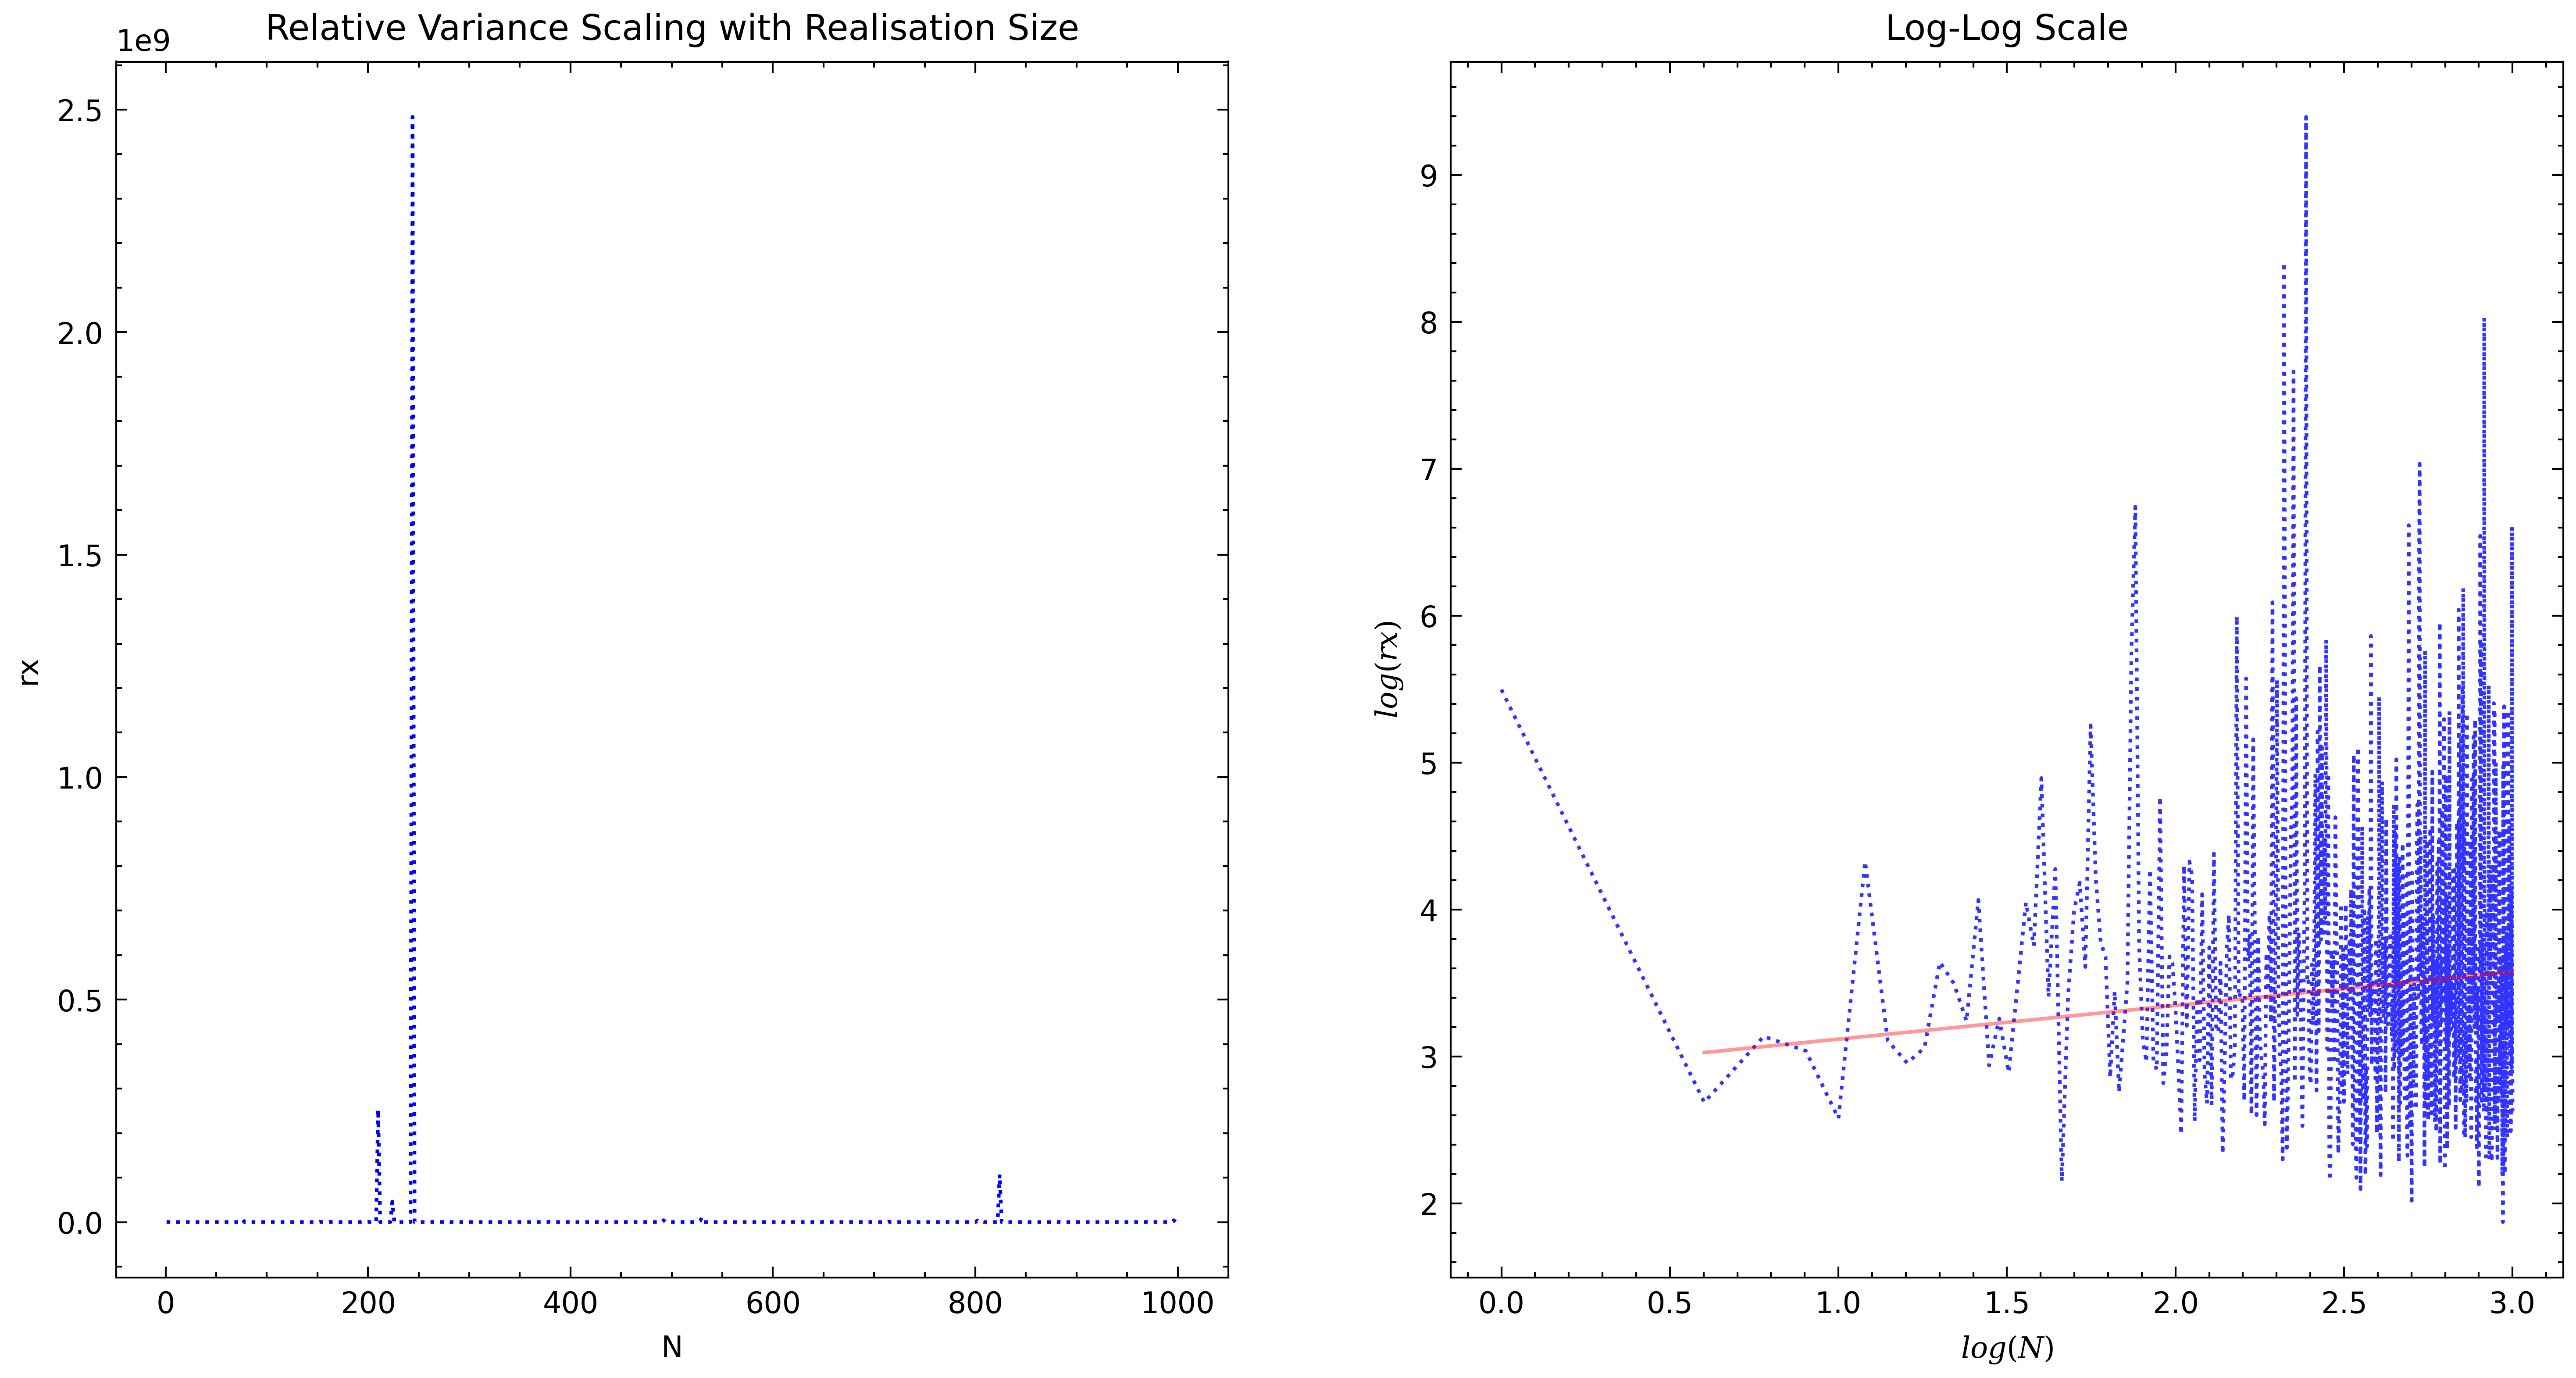

alpha = 0.22886683546603548


In [40]:
trunc_start, trunc_lim = int(0.3*len(kernel_sizes)), -1

sample_sub_idx = 1
sample_func = dloader.get_skstrip_func_flat(sample_sub_idx)[:]
size = sample_func.shape[0]
nsamples = 1000

rs_rxs = get_rxs_random_system(size*100, kernel_sizes, nsamples, mu=mu, sigma=sigma)
fits = get_fits(kernel_sizes, [ rs_rxs ], trunc_start=trunc_start, trunc_lim=trunc_lim)
fig, ax = plot_rxs(kernel_sizes, [ rs_rxs ], fit_plot_start=1, fits=fits)
print(f"alpha = {fits[0][0]}")

## Plotting $R_x$

In [51]:
# Loading sub_rxs from dir
T = 50
kernel_sizes, sub_rxs, subs = load_rxs_data(RXS_SAVE_DIR, t=T)
sub_rxs.shape

(89, 500)

In [52]:
PLOTS_SAVE_DIR = os.path.join(PLOTS_SAVE_PARENT_DIR, str(T))
if not os.path.exists(PLOTS_SAVE_DIR):
    os.makedirs(PLOTS_SAVE_DIR)

In [47]:
def get_fits(kernel_sizes, sub_rxs, trunc_lim=None, trunc_start=None):
    if type(trunc_lim) == type(None): trunc_lim = len(kernel_sizes)
    if type(trunc_start) == type(None): trunc_start = 0
    
    ns_log = np.log10(kernel_sizes)[trunc_start:trunc_lim]
    all_fit_res = []
    for i, sub in zip(range(len(sub_rxs)), subs):
        rx = sub_rxs[i]
        rx_log = np.log10(rx[trunc_start:trunc_lim])
        
        fit_res = np.polyfit(ns_log, rx_log, 1)
#         print(f'{sub}: Fitting to {str(rx_log)} and {str(ns_log)}; alpha: {fit_res[0]}')
        all_fit_res.append(fit_res)
    return np.array(all_fit_res)

In [48]:
def plot_rxs(kernel_sizes, sub_rxs, subs=None, fits=None, fit_plot_start=0, fit_plot_end=-1, t=0):
    if subs == None: subs = list(range(len(sub_rxs)))

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ns = np.array(kernel_sizes)
    for i, sub in zip(range(len(sub_rxs)), subs):
        rx = sub_rxs[i]
        c = [np.random.rand(), np.random.rand(), np.random.rand()]
        axs[0].plot(ns, rx, label=f'{i}-og', c='b', linestyle=':')


    axs[0].set_title("Relative Variance Scaling with Realisation Size")
    axs[0].set_ylabel("rx")
    axs[0].set_xlabel("N")

    ns_log = np.log10(ns)
    for i, sub in zip(range(len(sub_rxs)), subs):
        rx = sub_rxs[i]
        rx_log = np.log10(rx)
        c = [np.random.rand(), np.random.rand(), np.random.rand()] 
        axs[1].plot(ns_log, rx_log, label=f'{i}-og', c='b', linestyle=':', alpha=0.8)

        if type(fits) != type(None):
            x_ns_log = ns_log[fit_plot_start:fit_plot_end]
            axs[1].plot(x_ns_log, np.polyval(fits[i], x_ns_log), label=f'{fits[i][0]:.3f}', 
                        c='r', linestyle='-', alpha=0.4)

    axs[1].set_title("Log-Log Scale")
    axs[1].set_ylabel("$log(rx)$")
    axs[1].set_xlabel("$log(N)$")
    

#     plt.legend()
    plt.show()

    return fig, axs


In [57]:
def plot_alpha_dist(data, plots_save_dir=PLOTS_SAVE_DIR, t=0):
#     data = fits[:, 0]
    counts, bin_edges, _ = plt.hist(data, bins=40, density=True, alpha=0.5, label='Histogram', rasterized=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    popt, pcov = curve_fit(gaussian, bin_centers, counts)

    plt.axvline(np.mean(data), rasterized=True)
    plt.plot(bin_centers, gaussian(bin_centers, *popt), rasterized=True)
    plt.xlabel("$\\alpha$")
    plt.ylabel("$n$")
    plt.title(f"$\\alpha$ Distribution at $t={t}$")
    mu, sigma = popt[-2], popt[-1]
#     plt.text(x=0.05, y=0.9, s=f"$\\mu = {mu:.3f}$", fontsize=8, transform=plt.gca().transAxes)
#     plt.text(x=0.05, y=0.8, s=f"$\\sigma = {sigma:.3f}$", fontsize=8, transform=plt.gca().transAxes)

#     plt.savefig(os.path.join(plots_save_dir, "alpha-distribution.eps"), format='eps', dpi=1200)
    plt.savefig(os.path.join(plots_save_dir, "alpha-distribution.pdf"), format='pdf', dpi=1200)
    return 

In [114]:
def plot_log_rx(kernel_sizes, sub_rxs, mu=mu, sigma=sigma, plots_save_dir=PLOTS_SAVE_DIR, t=0, **kwargs):
    marker_size = 3
    pcolors = [ ["#2C3E50", "#182035", "#D8E5F2"], ["#FF4136", "#D9000E"] ]

    # Plotting main data and fit for original
    rxs = sub_rxs
    trunc_start, trunc_end = kwargs.get("trunc_start", 0.0), kwargs.get("trunc_end", 1)
    trunc_start, trunc_end = int(trunc_start*len(kernel_sizes)), int(trunc_end*len(kernel_sizes))
    ns_log = np.log10(kernel_sizes)
    y_mean = np.nanmean(np.log10(rxs), axis=0)
    y_std = np.nanstd(np.log10(rxs), axis=0)
    fit = np.polyfit(ns_log[trunc_start:trunc_end], y_mean[trunc_start:trunc_end], 1)
    alpha = fit[0]
    print(f"alpha:\t\t\t{alpha}")

    plt.fill_between(ns_log, y_mean + y_std, y_mean - y_std, color=pcolors[0][2], rasterized=True)
    plt.scatter(ns_log, y_mean, s=marker_size, label="$m_{fMRI}" + f"={fit[0]:.3f}$", rasterized=True, color=pcolors[0][0])
    plt.plot(ns_log, np.polyval(fit, ns_log), linestyle='--', rasterized=True, color=pcolors[0][1])

    # Plotting for random Gaussian system
    r_kernel_sizes = kernel_sizes
    r_ns_log = np.log10(r_kernel_sizes)
    rs_rxs = get_rxs_random_system(size*100, r_kernel_sizes, 100, mu=mu, sigma=sigma)
    rx_log = np.log10(rs_rxs)
    # fits = get_fits(kernel_sizes, [ rs_rxs ], trunc_start=trunc_start, trunc_lim=trunc_lim)
    # fig, ax = plot_rxs(kernel_sizes, [ rs_rxs ], fit_plot_start=1, fits=fits)
    r_fit = np.polyfit(r_ns_log, rx_log, 1)
    m_rand_label = "$m_{Norm(" +  f"{mu:.3e}, {sigma:.3e}" + ")} =" + f"{r_fit[0]:.3f}$"
    plt.scatter(r_ns_log, rx_log, marker='o', s=marker_size, label=m_rand_label, color=pcolors[1][0], rasterized=True)
    plt.plot(r_ns_log, np.polyval(r_fit, r_ns_log), linestyle='--', color=pcolors[1][1], rasterized=True)
    r_alpha = r_fit[0]
    print(f"random system alpha:\t{r_alpha}")


    plt.legend(fontsize=8, loc=3)
    plt.xlabel("$log_{10}(N)$")
    plt.ylabel("$log_{10}(R_x)$")
    plt.title(f"Log-log Distribution of $R_x$ at $t={t}$")

#     plt.savefig(os.path.join(plots_save_dir, "log-rx_vs_log-n.eps"), format='eps', dpi=1200)
    plt.savefig(os.path.join(plots_save_dir, "log-rx_vs_log-n.pdf"), format='pdf', dpi=1200)
    plt.show()
    return alpha, r_alpha

In [87]:
trunc_start, trunc_lim = int(0.0*len(kernel_sizes)), -1
fits = get_fits(kernel_sizes, sub_rxs, trunc_start=trunc_start, trunc_lim=trunc_lim)

alphas = fits[:, 0]
print(f"Alpha mean: {np.nanmean(alphas)}, std: {np.nanstd(alphas)}")
print(f"Alpha min: {min(alphas)}, max: {max(alphas)}")

Alpha mean: -0.5362174849413012, std: 0.2768145002641573
Alpha min: -0.9873702750680721, max: 0.524095099999798


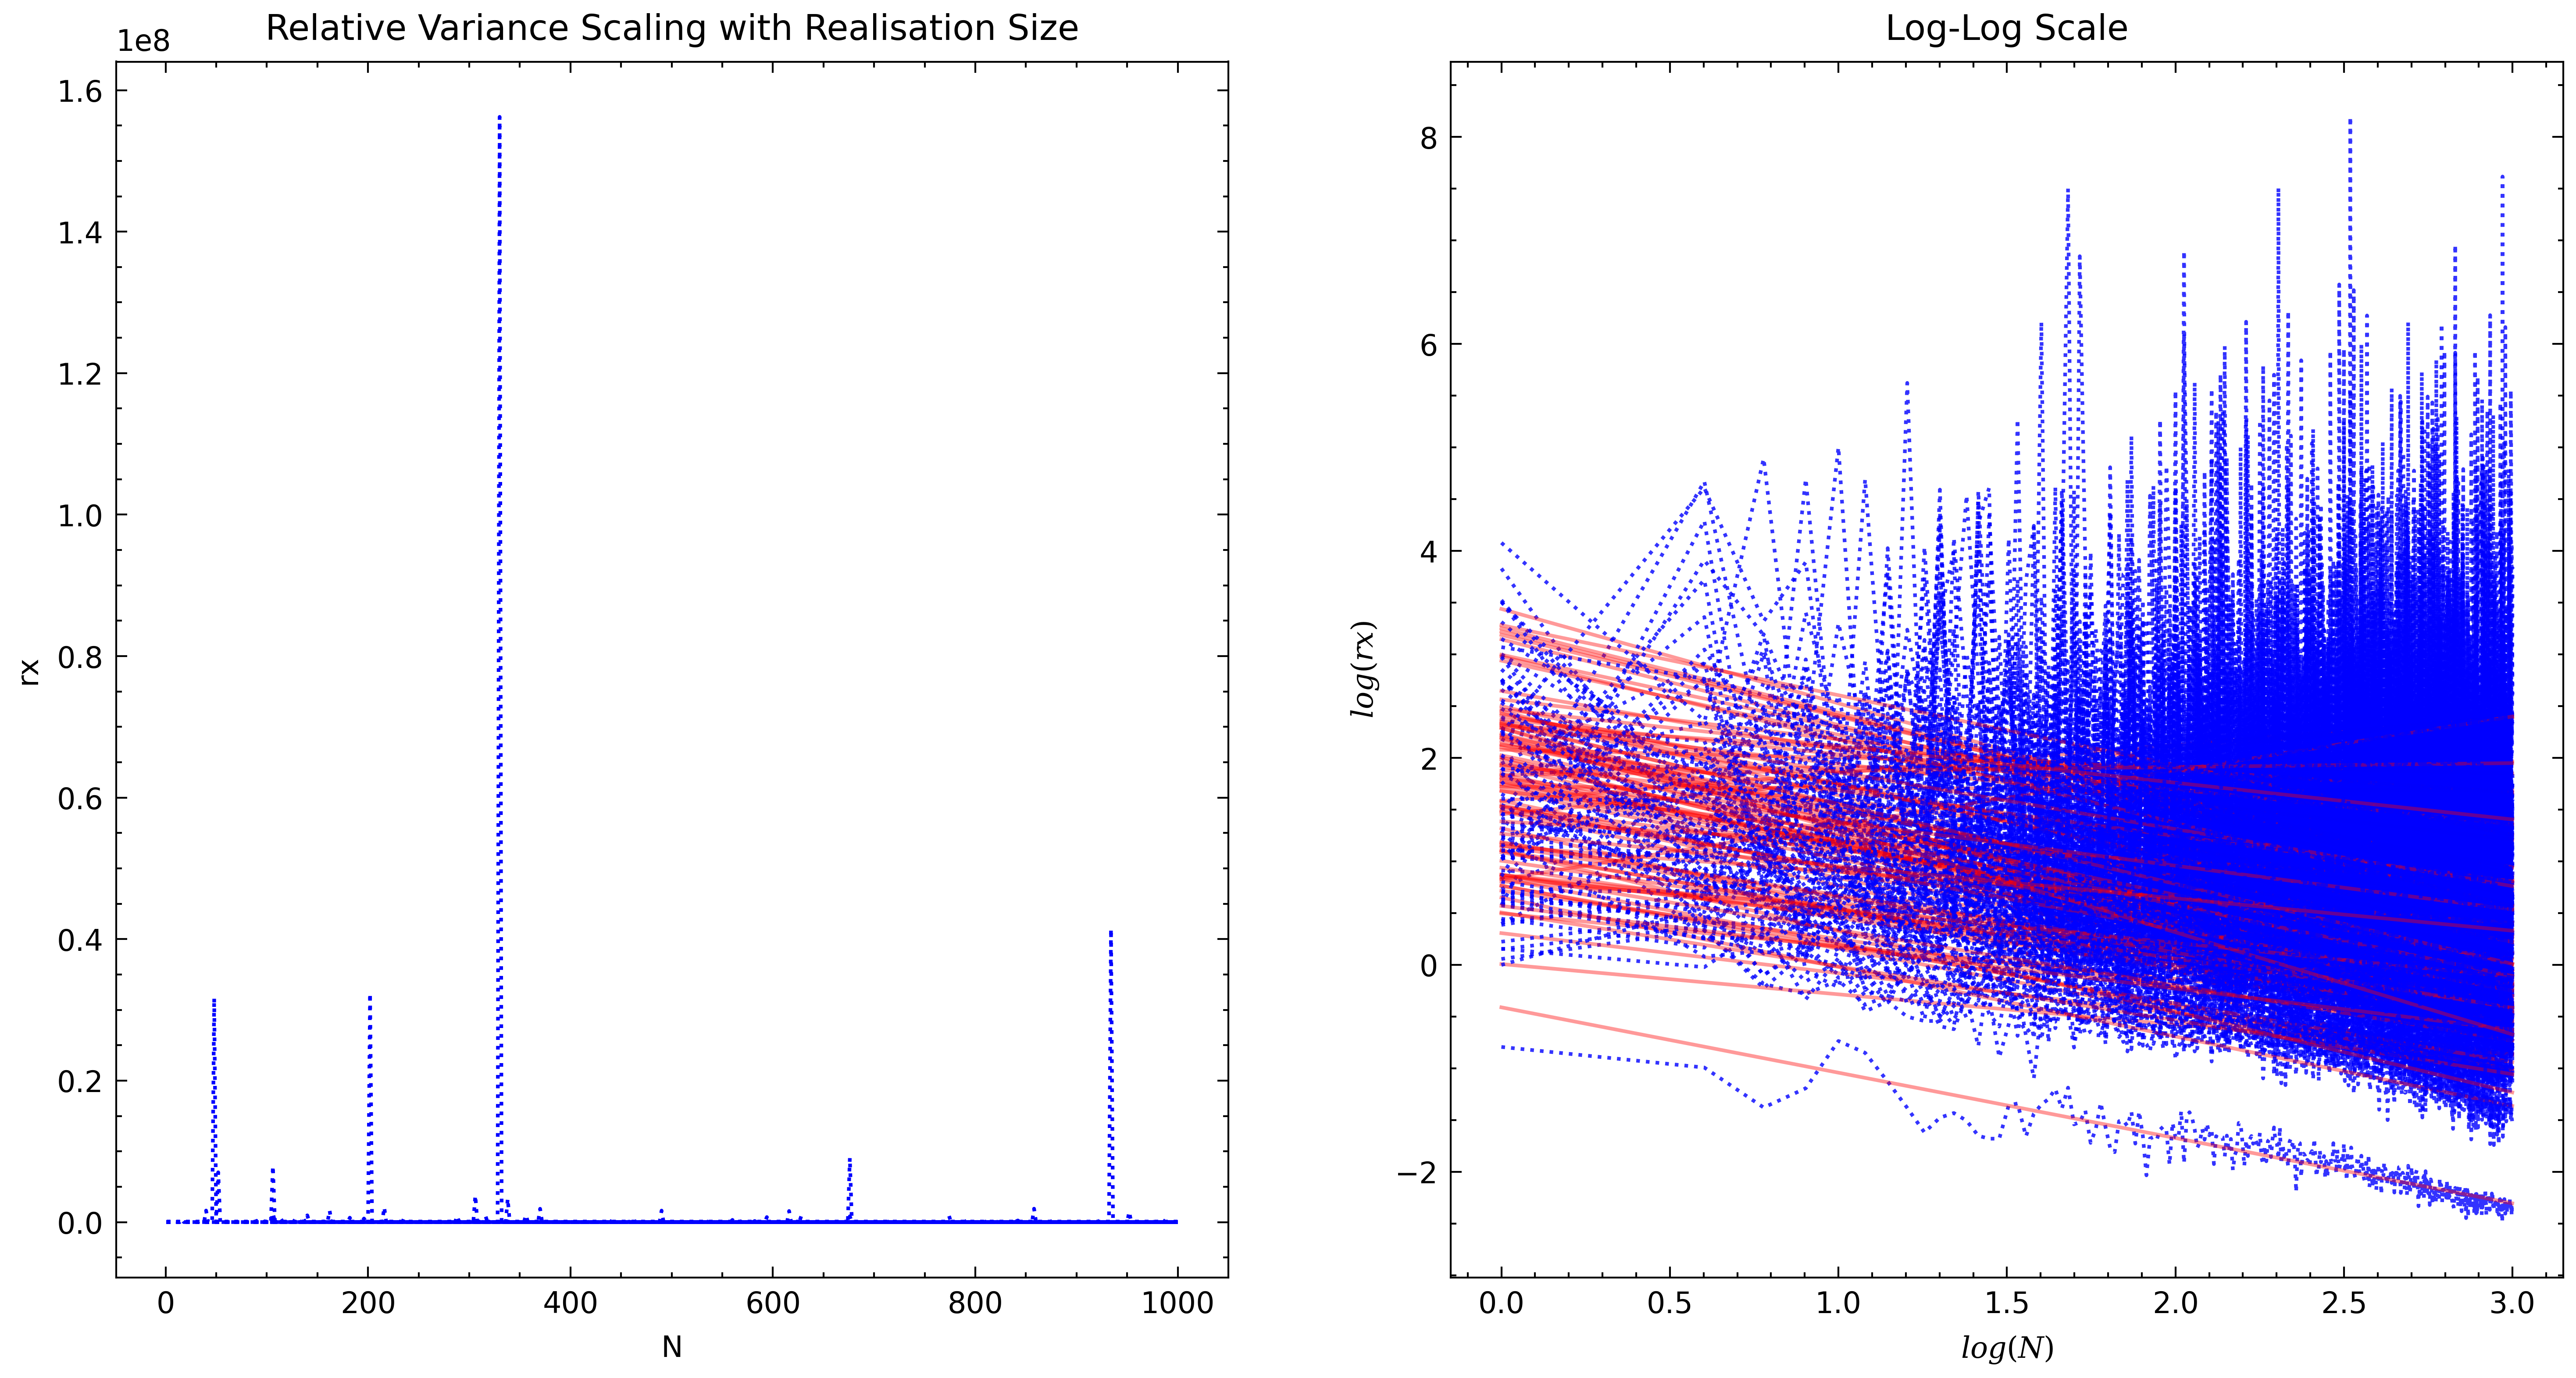

In [86]:
fig, ax = plot_rxs(kernel_sizes, sub_rxs, subs=list(subs), fits=fits, fit_plot_start=0)
# fig, ax = plot_rxs(kernel_sizes, sub_rxs, subs=list(subs))
# ax.set_ylim(-1.5, 0)
# ax.plot(np.log(kernel_sizes), np.log(rs_rxs), label=f'random', linestyle='--', marker='+')


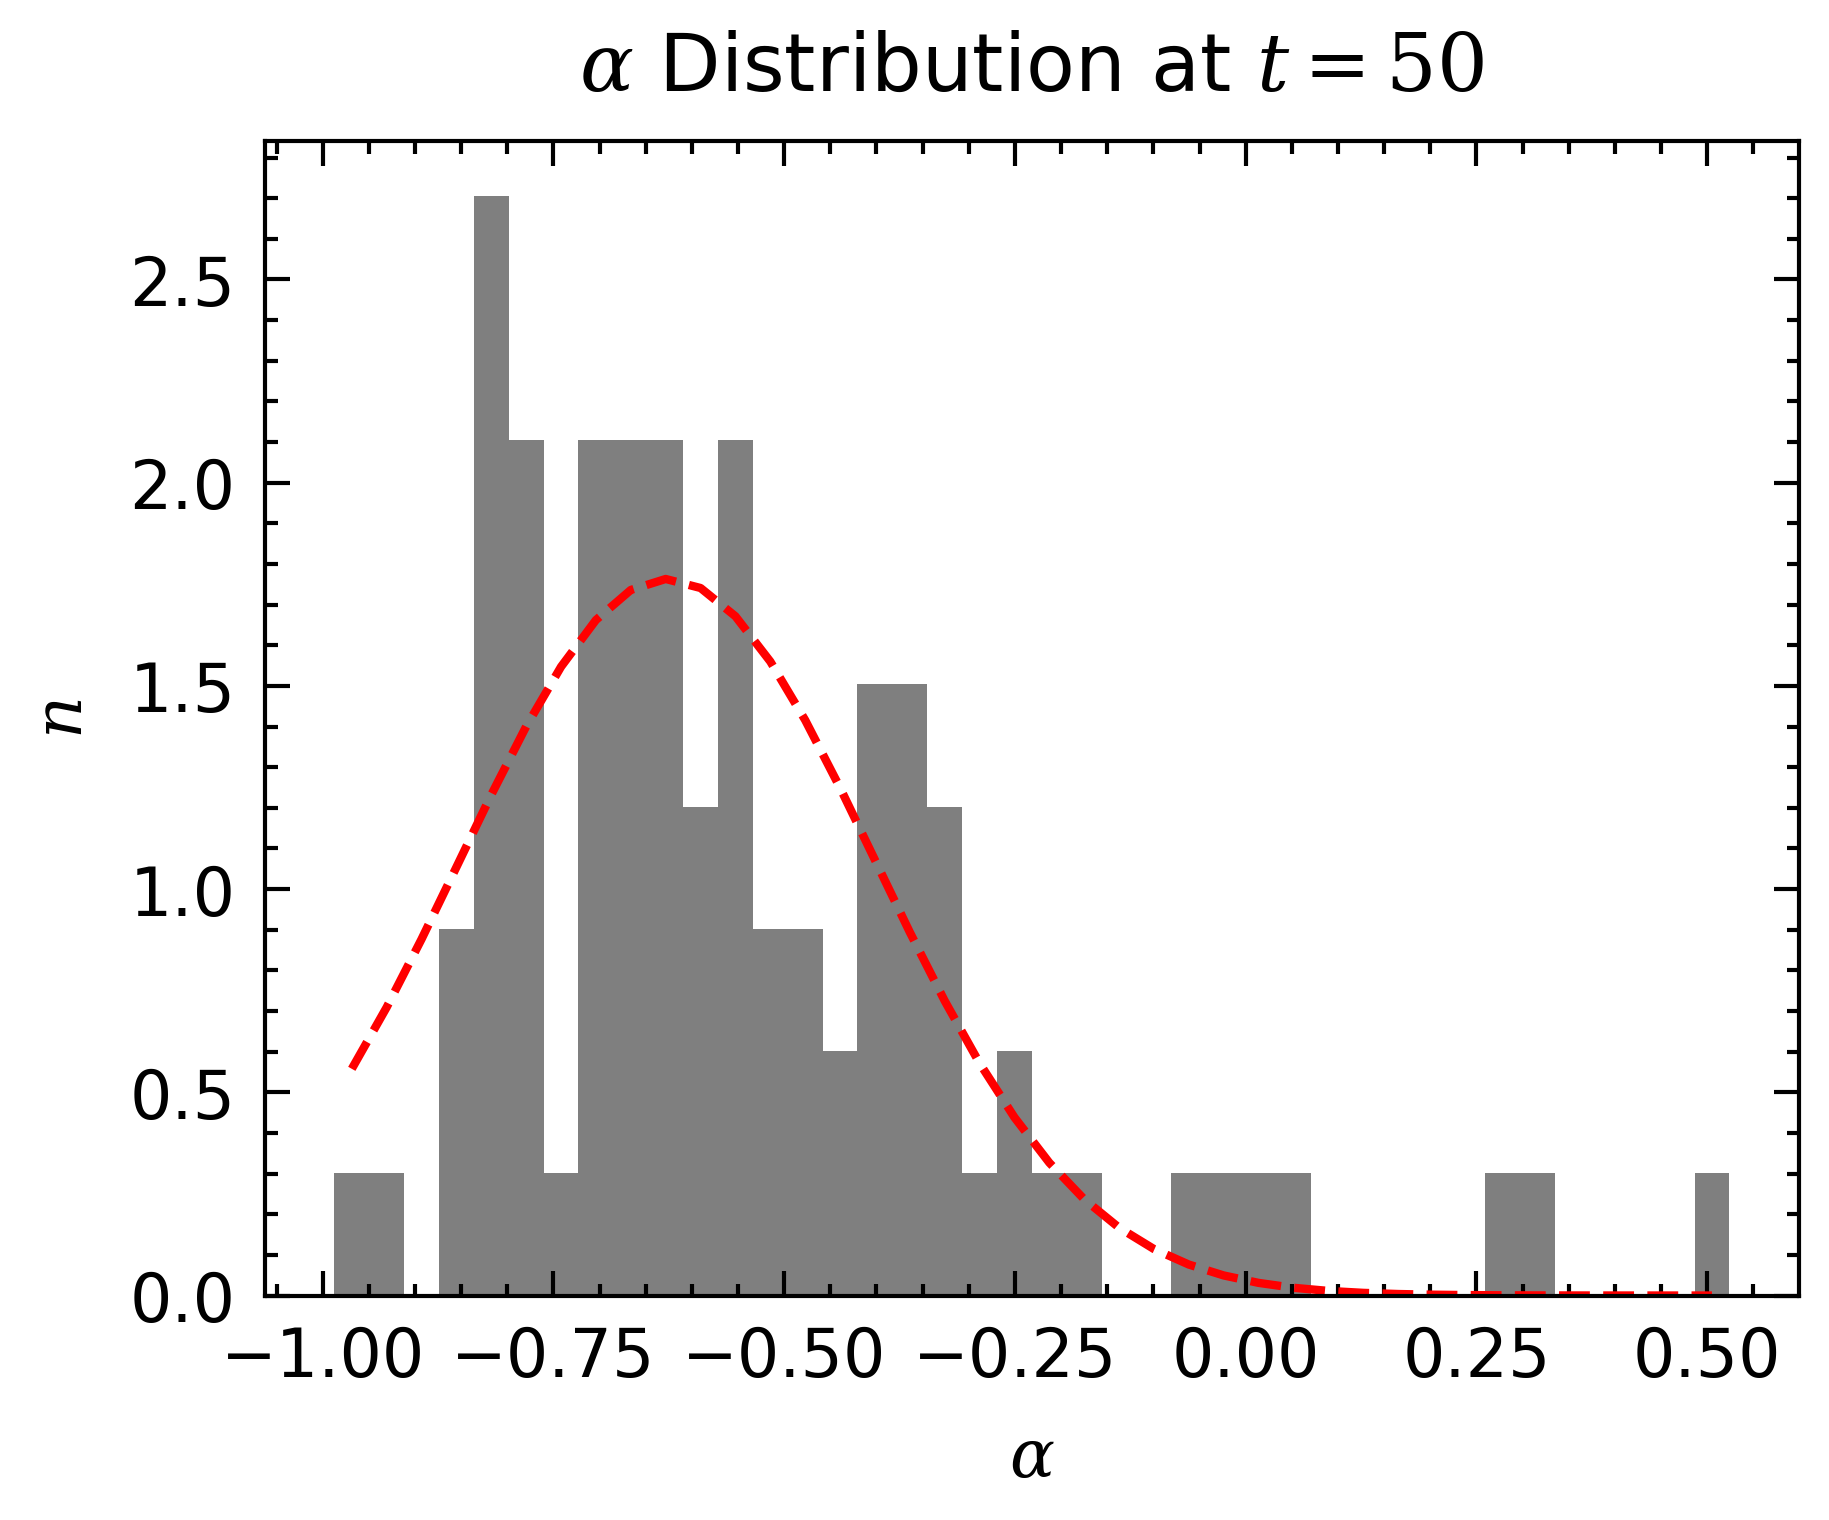

In [88]:
plot_alpha_dist(fits[:, 0], plots_save_dir=PLOTS_SAVE_DIR, t=T)

In [66]:
mu, sigma = 1, 1

In [113]:
def plot_log_rx_diag(kernel_sizes, sub_rxs, diag, mu=mu, sigma=sigma, plots_save_dir=PLOTS_SAVE_DIR, t=0, **kwargs):
    marker_size = 2

    pcolors = [ ["#E74C3C", "#B82E1E", "#96231C", "#F7D8D3"], ["#16A085", "#0F8166", "#186C57", "#CCF5EA"], ["#2ECC40", "#1F9D2E"] ]

    trunc_start, trunc_end = kwargs.get("trunc_start", 0.0), kwargs.get("trunc_end", 1)
    trunc_start, trunc_end = int(trunc_start*len(kernel_sizes)), int(trunc_end*len(kernel_sizes))
    
    # Plotting for CN subs
    rxs = sub_rxs[np.array(diag) == 0]
    cn_ns_log = np.log10(kernel_sizes)
    cn_y_mean = np.nanmean(np.log10(rxs), axis=0)
    cn_y_std = np.nanstd(np.log10(rxs), axis=0)
    cn_fit = np.polyfit(cn_ns_log[:trunc_start], cn_y_mean[:trunc_start], 1)
    cn_f_fit = np.polyfit(cn_ns_log[trunc_start:trunc_end], cn_y_mean[trunc_start:trunc_end], 1)
    print(f"CN alpha = {cn_fit[0]}")

    # Plotting for AD subs
    rxs = sub_rxs[np.array(diag) == 1]
    ad_ns_log = np.log10(kernel_sizes)
    ad_y_mean = np.nanmean(np.log10(rxs), axis=0)
    ad_y_std = np.nanstd(np.log10(rxs), axis=0)
    ad_fit = np.polyfit(ad_ns_log[:trunc_start], ad_y_mean[:trunc_start], 1)
    ad_f_fit = np.polyfit(ad_ns_log[trunc_start:trunc_end], ad_y_mean[trunc_start:trunc_end], 1)
    print(f"AD alpha = {ad_fit[0]}")

    # plt.scatter(ad_ns_log, ad_y_mean)
    plt.fill_between(cn_ns_log, cn_y_mean + cn_y_std, cn_y_mean - cn_y_std, rasterized=True, color=pcolors[0][3], alpha=0.5)
    plt.fill_between(ad_ns_log, ad_y_mean + ad_y_std, ad_y_mean - ad_y_std, rasterized=True, color=pcolors[1][3], alpha=0.5)

    cn_label = "$m_{CN} = " + f"{cn_fit[0]:.3f}$\n" + "$m_{CN}^* = " + f"{cn_f_fit[0]:.3f}$"
    plt.scatter(cn_ns_log, cn_y_mean, label=cn_label, s=marker_size, rasterized=True, color=pcolors[0][0])
    plt.plot(cn_ns_log, np.polyval(cn_fit, cn_ns_log), linestyle='--', rasterized=True, color=pcolors[0][1])
    plt.plot(cn_ns_log, np.polyval(cn_f_fit, cn_ns_log), linestyle=':', rasterized=True, color=pcolors[0][2])

    ad_label = "$m_{AD} = " + f"{ad_fit[0]:.3f}$\n" + "$m_{AD}^* = " + f"{ad_f_fit[0]:.3f}$"
    plt.scatter(ad_ns_log, ad_y_mean, label=ad_label, s=marker_size, rasterized=True, color=pcolors[1][0])
    plt.plot(ad_ns_log, np.polyval(ad_fit, ad_ns_log), linestyle='--', rasterized=True, color=pcolors[1][1])
    plt.plot(ad_ns_log, np.polyval(ad_f_fit, ad_ns_log), linestyle=':', rasterized=True, color=pcolors[1][2])


    # Plotting for random Gaussian system
    r_kernel_sizes = kernel_sizes
    r_ns_log = np.log10(r_kernel_sizes)
    rs_rxs = get_rxs_random_system(size*100, r_kernel_sizes, 100, mu=mu, sigma=sigma)
    rx_log = np.log10(rs_rxs)
    # fits = get_fits(kernel_sizes, [ rs_rxs ], trunc_start=trunc_start, trunc_lim=trunc_lim)
    # fig, ax = plot_rxs(kernel_sizes, [ rs_rxs ], fit_plot_start=1, fits=fits)
    r_fit = np.polyfit(r_ns_log, rx_log, 1)
    m_rand_label = "$m_{Norm(" +  f"{mu:.3e}, {sigma:.3e}" + ")} =" + f"{r_fit[0]:.3f}$"
    plt.scatter(r_ns_log, rx_log, marker='o', s=marker_size, label=m_rand_label, rasterized=True, color=pcolors[2][0])
    plt.plot(r_ns_log, np.polyval(r_fit, r_ns_log), linestyle='--', rasterized=True, color=pcolors[2][1])
    print(f"random system alpha:\t{r_fit[0]}")


    plt.legend(fontsize=6, loc=3)
    plt.xlabel("$log_{10}(N)$")
    plt.ylabel("$log_{10}(R_x)$")
    plt.title(f"Log-log Distribution of $R_x$ at $t={t}$")
#     plt.savefig(os.path.join(plots_save_dir, "ad-cn_log-rx_vs_log-n.eps"), format='eps', dpi=1200)
    plt.savefig(os.path.join(plots_save_dir, "ad-cn_log-rx_vs_log-n.pdf"), format='pdf', dpi=1200)
    plt.show()
    return cn_fit[0], ad_fit[0], r_fit[0]

CN alpha = -0.4511250902250662
AD alpha = -0.4793685265745432
random system alpha:	-1.011627093589629


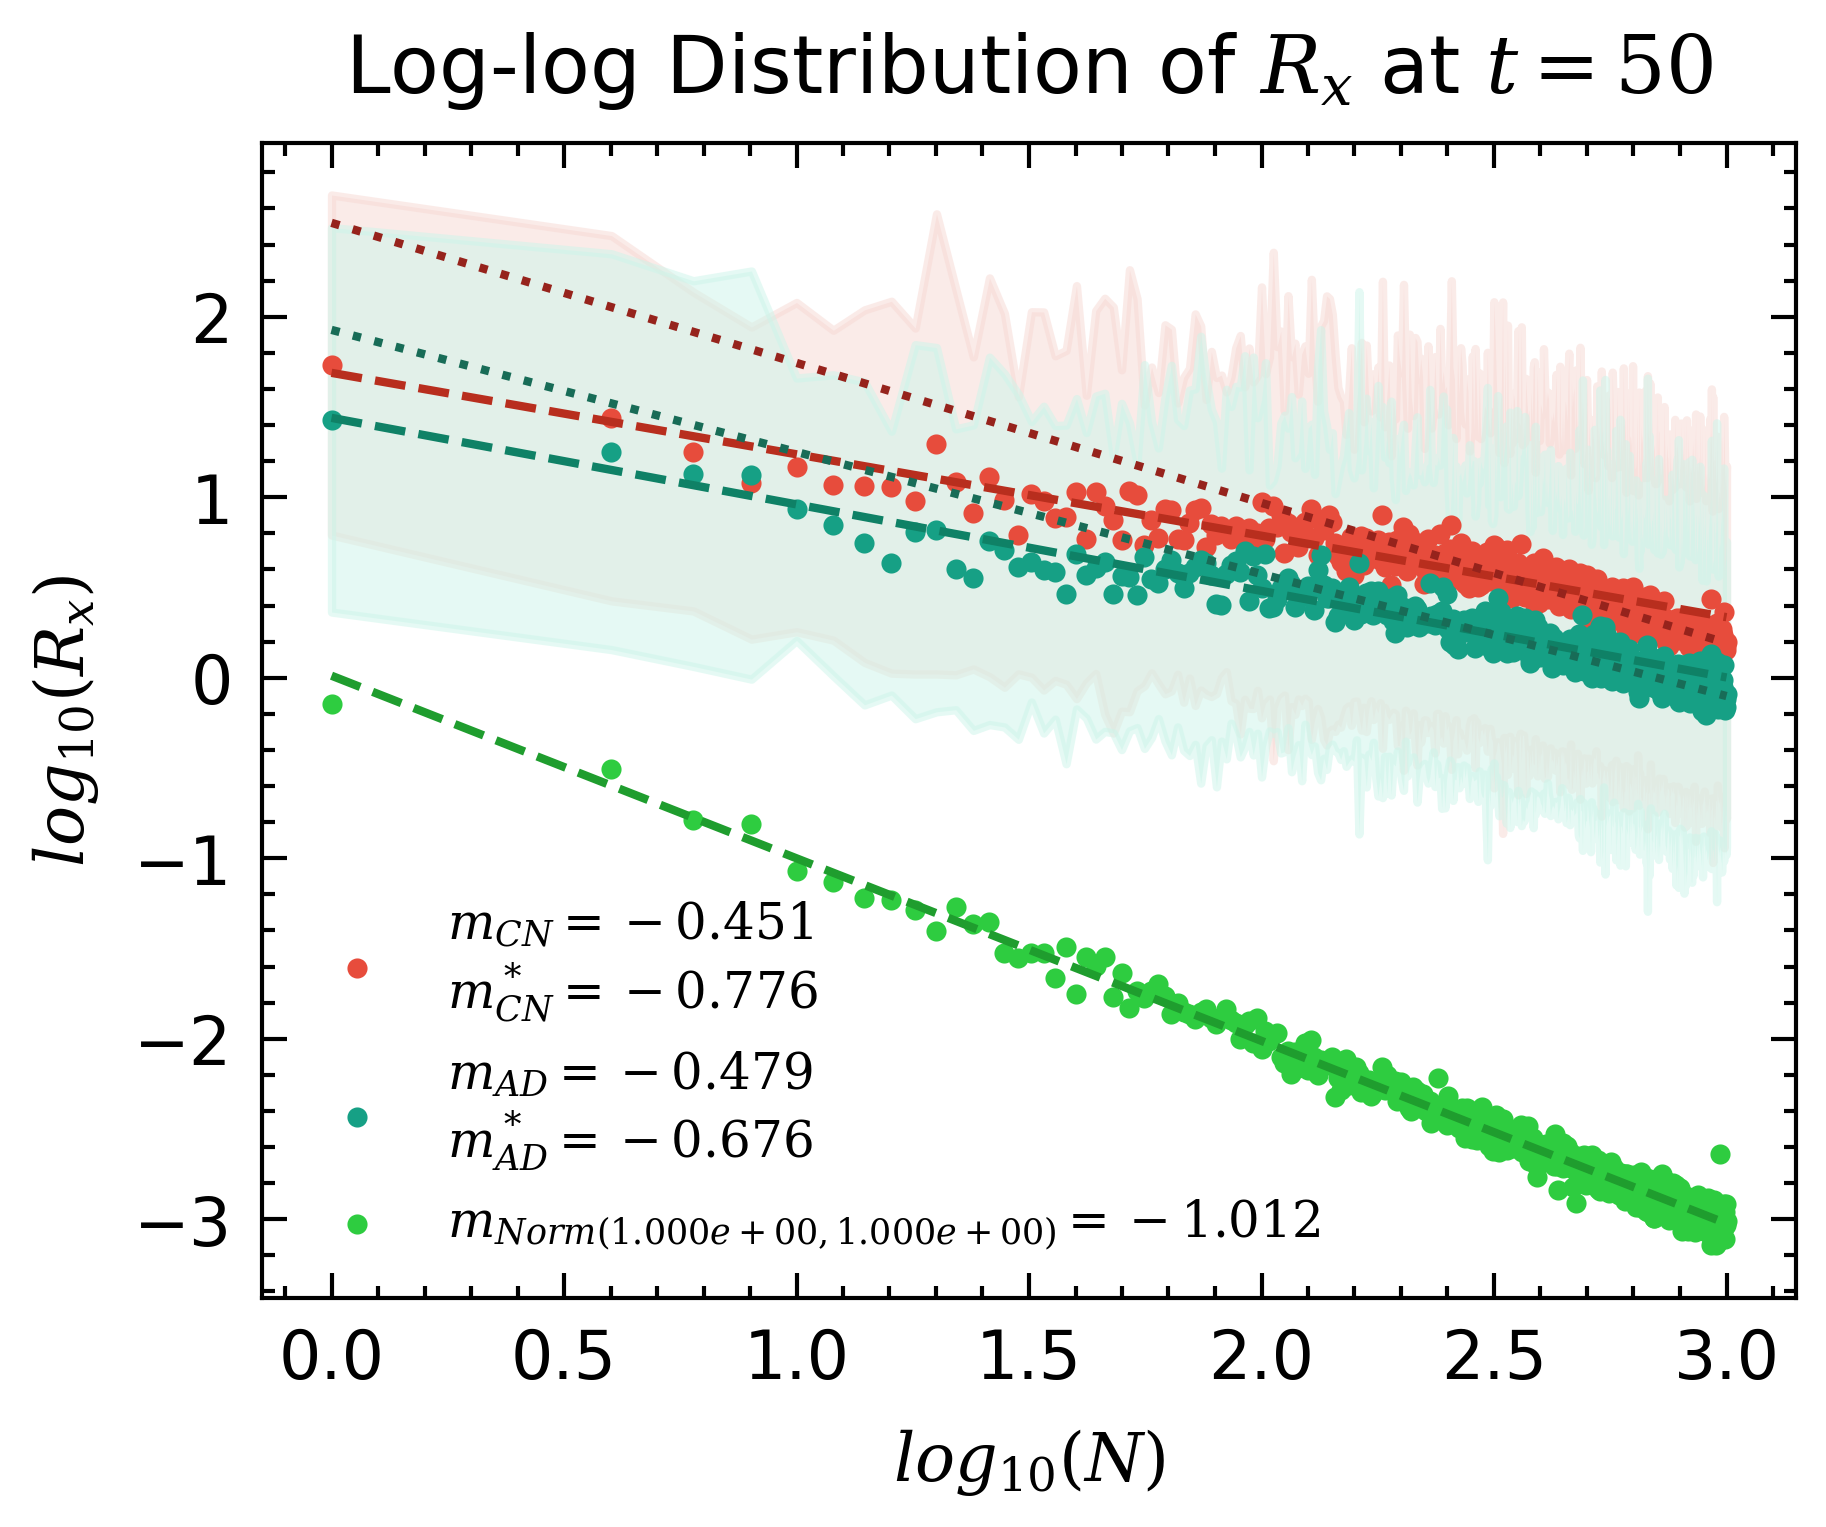

(-0.4511250902250662, -0.4793685265745432, -1.011627093589629)

In [115]:
trunc_start, trunc_end = 0.6, 1.0
plot_log_rx_diag(
    kernel_sizes, sub_rxs, dloader.diag, 
    mu=mu, sigma=sigma, 
    plots_save_dir=PLOTS_SAVE_DIR,
    trunc_start=trunc_start, trunc_end=trunc_end,
    t=T
)

alpha:			-0.651371377321052
random system alpha:	-1.0073201349091512


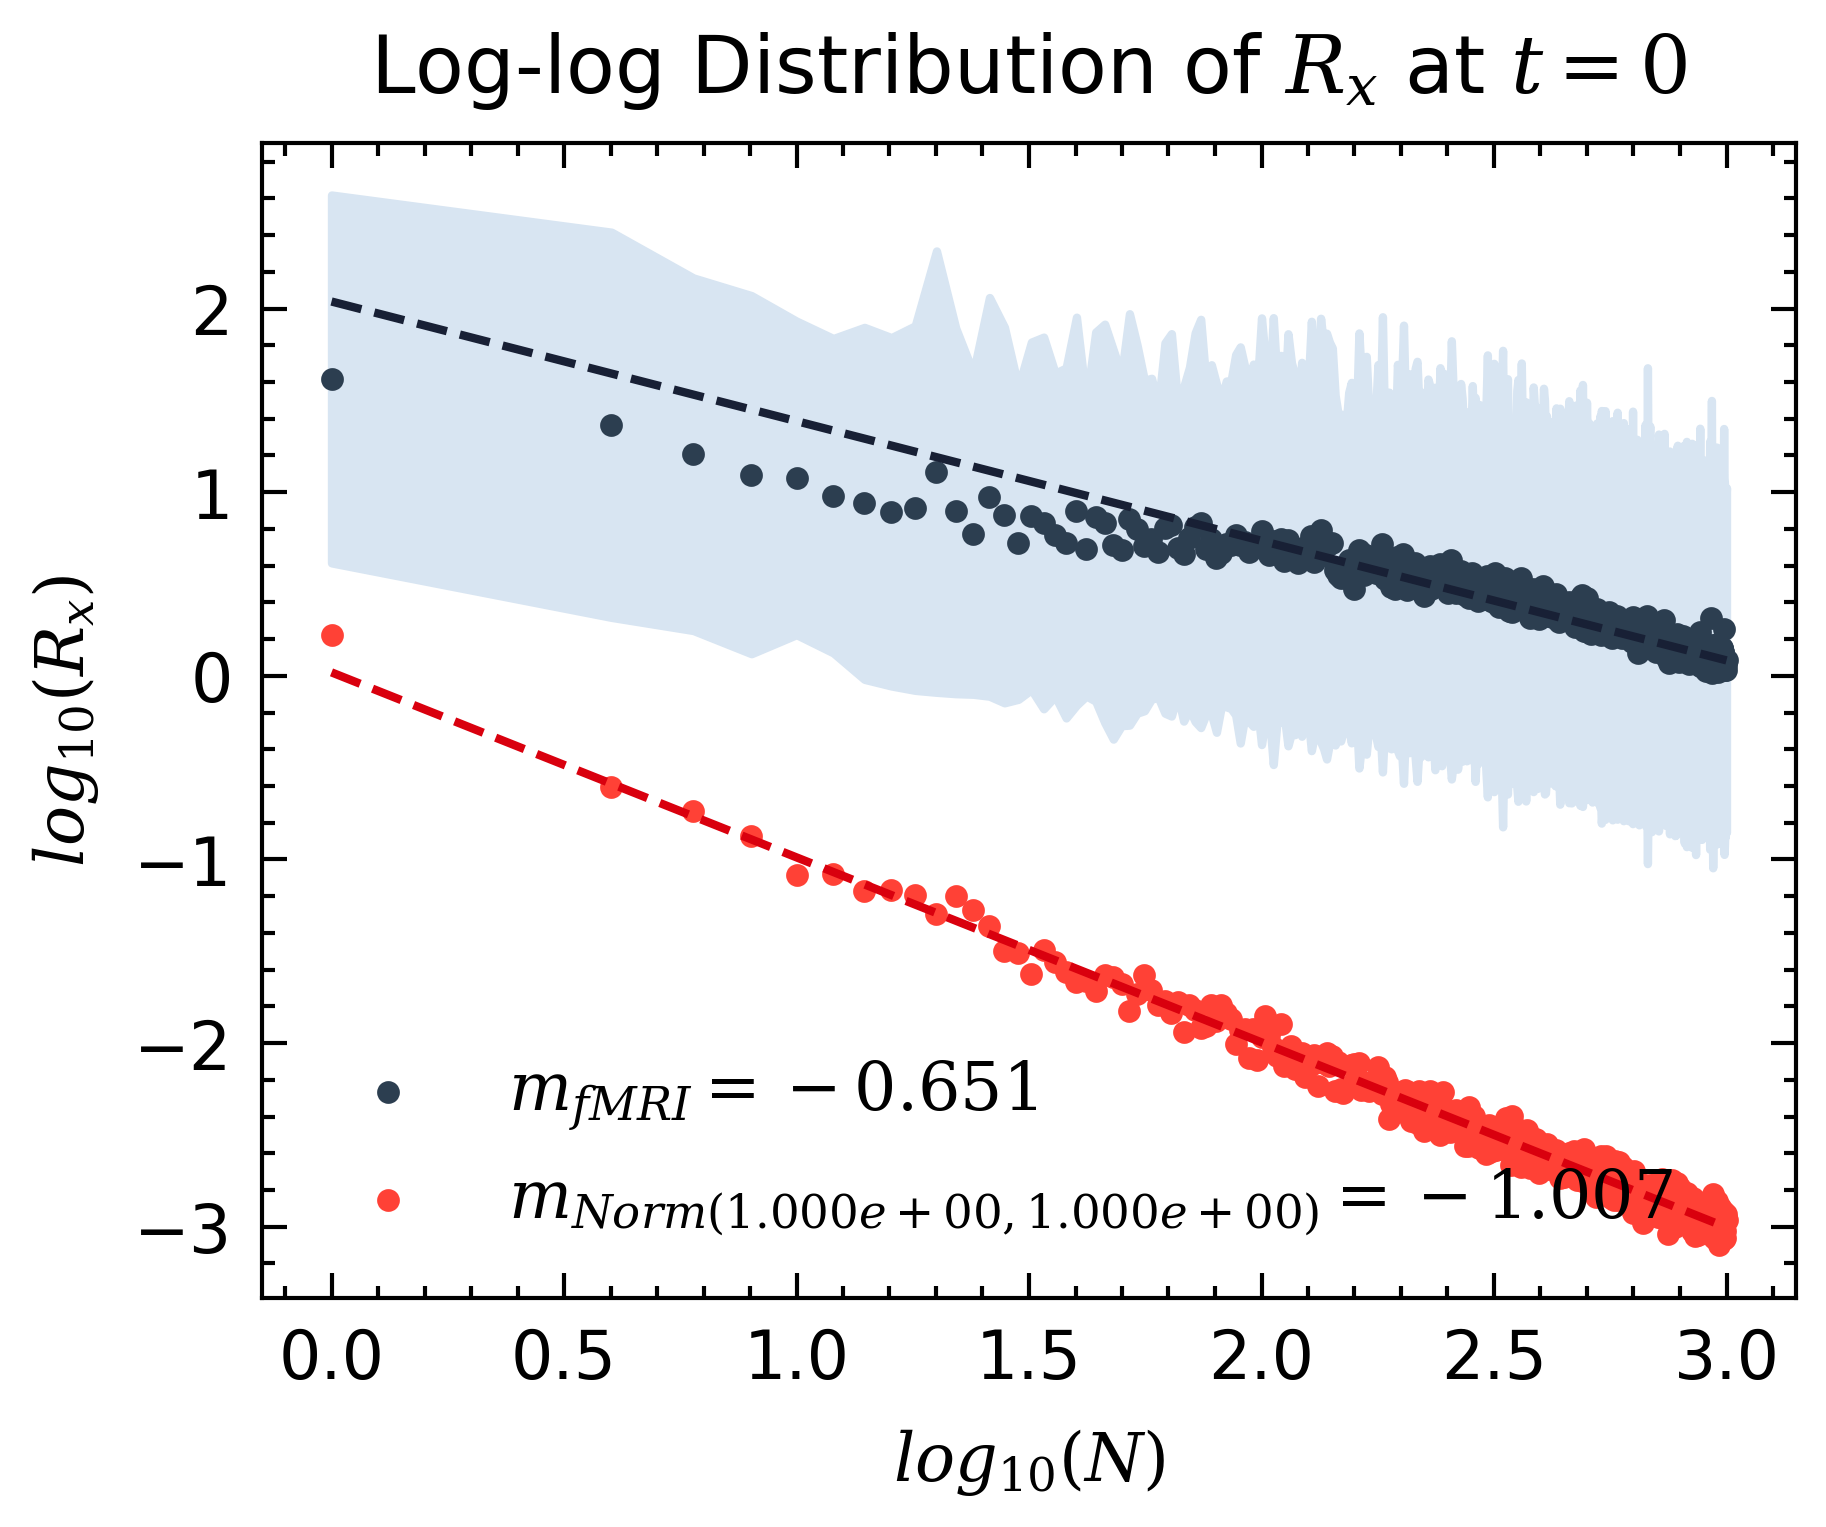

(-0.651371377321052, -1.0073201349091512)

In [116]:
trunc_start, trunc_end = 0.8, 1.0
plot_log_rx(
    kernel_sizes, sub_rxs, 
    mu=mu, sigma=sigma, 
    plots_save_dir=PLOTS_SAVE_DIR,
    trunc_start=trunc_start, trunc_end=trunc_end
)

In [152]:
# realisations = np.floor(228938/kernel_sizes)
# r_fits = get_fits(realisations, sub_rxs, trunc_lim=trunc_lim)
# plot_rxs_realisations(kernel_sizes, sub_rxs, subs=subs, fits=r_fits)
# print(f"Alpha mean: {np.mean(r_fits[:, 0])}, std: {np.std(r_fits[:, 0])}")

In [153]:
# data = r_fits[:, 0]
# counts, bin_edges, _ = plt.hist(data, bins=20, density=True, alpha=0.5, label='Histogram')
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# popt, pcov = curve_fit(gaussian, bin_centers, counts)

# plt.axvline(np.mean(data))
# plt.plot(bin_centers, gaussian(bin_centers, *popt))
# plt.xlabel("$\\alpha$")
# plt.ylabel("$n$")
# plt.title("$\\alpha$ Distribution for System Size Scaling")

# Power Spectrum Calculation

In [104]:
sample_sub_idx = 10
data = dloader.get_skstrip_func_flat(sample_sub_idx)
# data = dloader.get_z_sk_func(sample_sub_idx)

In [110]:
fft_data = np.fft.fft(data, axis=0)
power_spectrum = np.abs(fft_data)**2

Text(0, 0.5, 'Power')

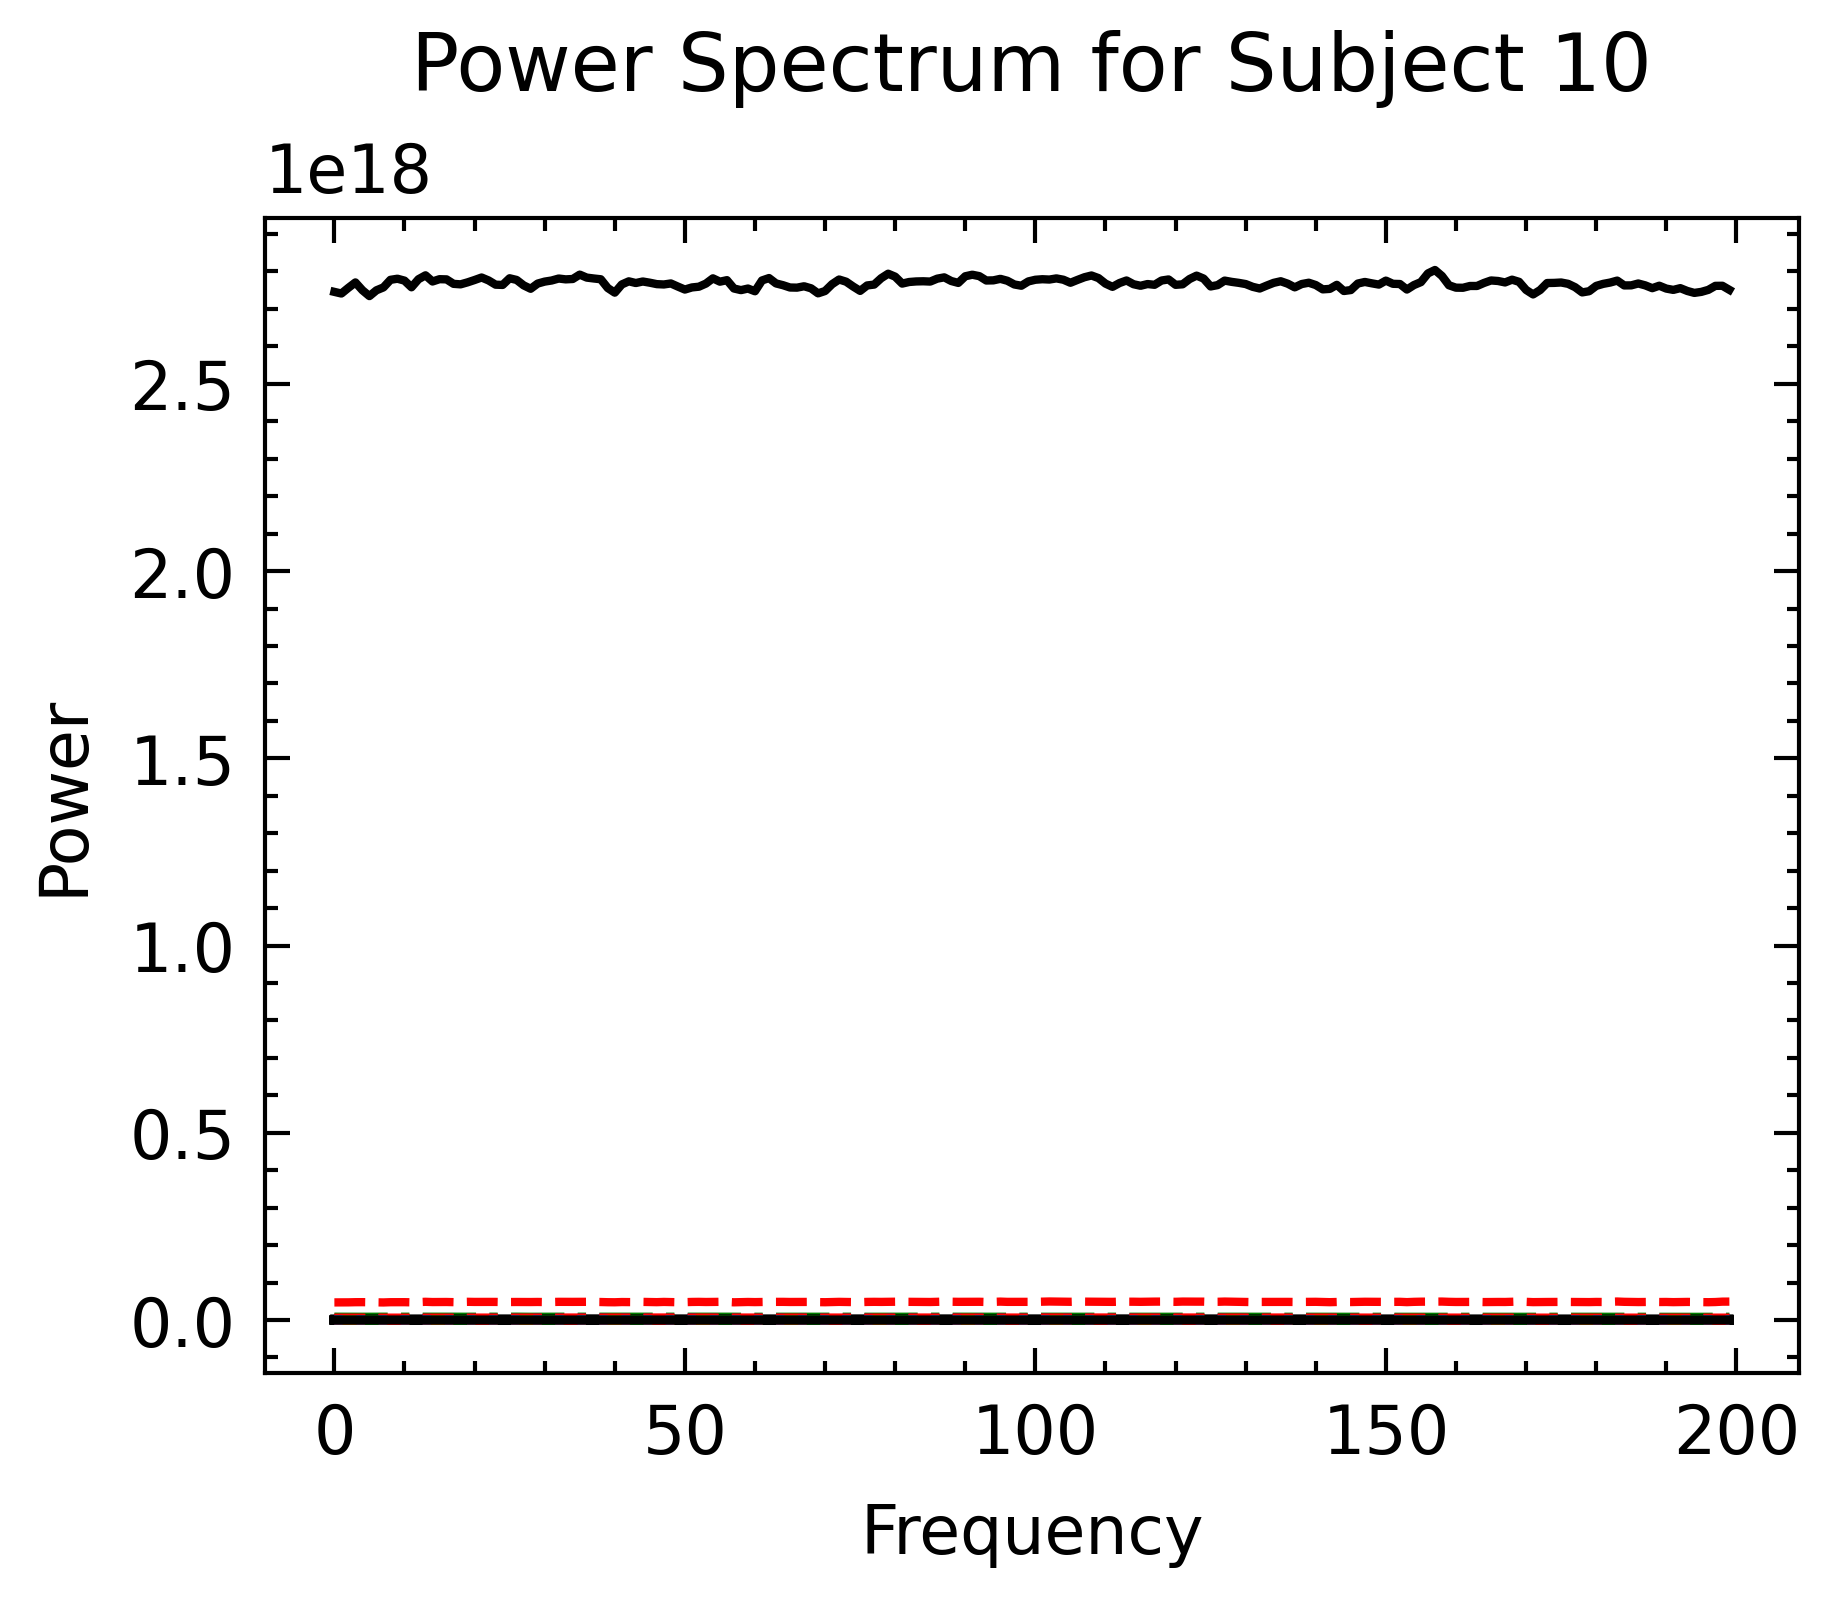

In [112]:
for i in range(0, data.shape[0]):
    if i > 1000: break
    plt.plot(power_spectrum[i], label=str(i))
# plt.legend()
# plt.xlim(0, 2)
plt.title(f"Power Spectrum for Subject {sample_sub_idx}")
plt.xlabel("Frequency")
plt.ylabel("Power")

# Main End
---------------------------------------------------------
<br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/>

In [125]:
stic = time.time()
ad_rxs = []
# ns = [2**i for i in range(16)]
ns = np.array([i for i in range(1, 100, 5)])
for idx, sub in enumerate([ *dloader.cn_subs[:2], *dloader.ad_subs[:2] ]):
    istic = time.time()
    ts = dloader.get_func(sub).get_fdata()[:, :, :, 0]
    
#     np.random.shuffle(ts_flat)
    rx = get_rx(ts, ns)
    
#     ts_flat_s = np.array(ts_flat)
#     np.random.shuffle(ts_flat)
#     rx_s = get_rx(ts, ns)    
    sub_rxs.append([rx, rx_s])
    print(f"{idx}: Done with subject {sub}; took {time.time()-istic} s")

At n=1
At n=6
At n=11
At n=16
At n=21
At n=26
At n=31
At n=36
At n=41
At n=46
At n=51
At n=56
At n=61
At n=66
At n=71
At n=76
At n=81
At n=86
At n=91
At n=96
0: Done with subject 130_S_4343; took 1.6409783363342285 s
At n=1


/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


At n=6
At n=11
At n=16
At n=21
At n=26
At n=31
At n=36
At n=41
At n=46
At n=51
At n=56
At n=61
At n=66
At n=71
At n=76
At n=81
At n=86
At n=91
At n=96
1: Done with subject 012_S_4026; took 1.5019662380218506 s
At n=1
At n=6
At n=11
At n=16
At n=21
At n=26
At n=31
At n=36
At n=41
At n=46
At n=51
At n=56
At n=61
At n=66
At n=71
At n=76
At n=81
At n=86
At n=91
At n=96
2: Done with subject 130_S_4990; took 1.541414499282837 s
At n=1
At n=6
At n=11
At n=16
At n=21
At n=26
At n=31
At n=36
At n=41
At n=46
At n=51
At n=56
At n=61
At n=66
At n=71
At n=76
At n=81
At n=86
At n=91
At n=96
3: Done with subject 130_S_5006; took 1.512035608291626 s


130_S_4343: alpha: nan nan
012_S_4026: alpha: nan nan
130_S_4990: alpha: nan nan
130_S_5006: alpha: nan nan


/tmp/ipykernel_7355/2923290983.py:4: RuntimeWarning: divide by zero encountered in log
  rx_log = np.log(rx[0])
/tmp/ipykernel_7355/2923290983.py:5: RuntimeWarning: divide by zero encountered in log
  rx_log_s = np.log(rx[1])


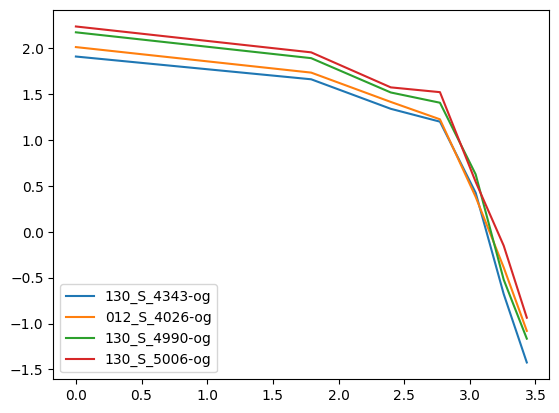

In [128]:
all_fit_res = []
for rx, sub in zip(sub_rxs, [ *dloader.cn_subs[:2], *dloader.ad_subs[:2] ]):
    ns_log = np.log(ns)
    rx_log = np.log(rx[0])
    rx_log_s = np.log(rx[1])
#     plt.plot(ns, rx[0], label=f'{sub}-og')
    plt.plot(ns_log, rx_log, label=f'{sub}-og')
#     plt.plot(ns_log, rx_log_s, label=f'{sub}-shuffle')
    fit_res = np.polyfit(ns_log, rx_log, 1)
    fit_res_s = np.polyfit(ns_log, rx_log_s, 1)
    print(f'{sub}: alpha: {fit_res[0]} {fit_res_s[0]}')
    all_fit_res.append([ fit_res, fit_res_s ])
#     plt.plot(ns_log, ns_log*fit_res[0] + fit_res[1], label=f'{sub}-fit')
plt.legend()
plt.show()

In [27]:

stic = time.time()
ad_rxs = []
ns = np.array([i for i in range(1, 200, 5)])
ad_rxs = Parallel(n_jobs=32)(delayed(get_rx_1d)(sub, ns) for sub in dloader.ad_subs)
# cn_subs = [sub for idx, sub in enumerate(dloader.subjects_list) if dloader.diag[idx] == 0]
# cn_rxs = Parallel(n_jobs=32)(delayed(get_rx_1d)(sub, ns) for sub in cn_subs)

In [28]:
ad_rxs = np.array(ad_rxs)
# cn_rxs = np.array(cn_rxs)
ad_rxs.shape, cn_rxs.shape

((34, 40), (55, 40))

In [29]:
np.save("results/ad_rxs_1d.npy", ad_rxs)
# np.save("results/cn_rxs_1d.npy", cn_rxs)

In [ ]:
ad_rxs_l = np.load("results/cn_rxs_1d.npy")
ad_rxs_l

In [ ]:
cn_subs

In [ ]:
ad_fit_res = []
for rx, sub in zip(ad_rxs, dloader.ad_subs):
    ns_log = np.log(ns)
    rx_log = np.log(rx)
#     plt.plot(ns, rx[0], label=f'{sub}-og')
    plt.plot(ns_log, rx_log, label=f'{sub}-og')
    fit_res = np.polyfit(ns_log, rx_log, 1)
    print(f'{sub}: alpha: {fit_res[0]}')
    ad_fit_res.append(fit_res)
    plt.plot(ns_log, ns_log*fit_res[0] + fit_res[1], label=f'{sub}-fit')
plt.legend()
plt.show()

cn_fit_res = []
for rx, sub in zip(cn_rxs, cn_subs):
    ns_log = np.log(ns)
    rx_log = np.log(rx)
    plt.plot(ns_log, rx_log, label=f'{sub}-og')
    fit_res = np.polyfit(ns_log, rx_log, 1)
    print(f'{sub}: alpha: {fit_res[0]}')
    cn_fit_res.append(fit_res)
    plt.plot(ns_log, ns_log*fit_res[0] + fit_res[1], label=f'{sub}-fit')
plt.legend()
plt.show()

In [44]:
ad_fit_res = np.array(ad_fit_res)
cn_fit_res = np.array(cn_fit_res)

Text(0.5, 0, '$\\alpha$')

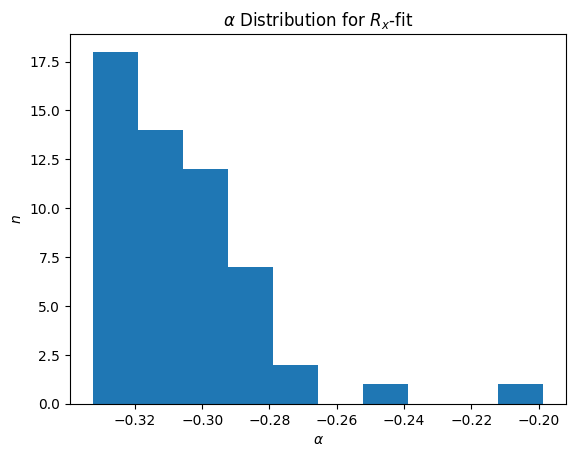

In [46]:
# plt.hist(ad_fit_res[:, 0], label='AD')
plt.hist(cn_fit_res[:, 0], label='CN')
plt.title("$\\alpha$ Distribution for $R_x$-fit")
plt.ylabel("$n$")
plt.xlabel("$\\alpha$")

In [ ]:
plt.hist(fit_res[:, 1])
plt.title("Intercept Distribution for $R_x$-fit")
plt.ylabel("$n$")
plt.xlabel("Intercept")